# 02: Baseline GWAS with Population Structure Correction

This notebook demonstrates the core statistical modeling pipeline. It takes the simulated, cached data from the previous step (`01_simulation.ipynb`) and applies a logistic regression model to identify genetic markers associated with insecticide resistance.

**Workflow:**
1.  **Load Data:** Load the cached variant data and the full sample metadata.
2.  **Simulate Phenotypes:** Generate the phenotype labels based on the loaded genotypes.
3.  **Prepare for Modeling:** Use a dedicated `AnalysisHelper` to create a modeling-ready DataFrame, including Principal Components (PCs) for population structure correction.
4.  **Fit Model:** Instantiate and fit the `LogisticRegressionGWAS` model.
5.  **Interpret & Visualize Results:** Analyze the model summary and plot the key findings to confirm the pipeline is working.

### Setup & Imports

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../src"))
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import roc_curve

# Import our custom classes
from data.simulation import ResistanceSimulator
from utils.phenotype_utils import PhenotypeHelper
from utils.analysis_utils import AnalysisHelper
from models.logistic_regression import LogisticRegressionGWAS

warnings.filterwarnings('ignore', category=FutureWarning)

### Load Data & Simulate Phenotypes

In [2]:
# --- Load Cached Data and Simulate Phenotypes ---

# Define the path to the cache file created by notebook 01.
CACHE_PATH = '../data/gwas_preprocessed_variants.nc'

# Verify that the cache file exists.
if not os.path.exists(CACHE_PATH):
    raise FileNotFoundError(
        f"Cache file not found at {CACHE_PATH}. "
        "Please run the '01_simulation.ipynb' notebook first to generate it."
    )

print(f"Loading variant data from cache: {CACHE_PATH}")
variant_ds = xr.open_dataset(CACHE_PATH)

# --- Simulate Phenotypes ---
sim = ResistanceSimulator()
g1 = variant_ds['call_genotype'].isel(variants=0).values
g2 = variant_ds['call_genotype'].isel(variants=1).values
pheno_series = sim.simulate_phenotypes(g1, g2)

# --- Assemble Final Dataset for Analysis ---
pheno_df = sim.create_phenotype_df(pheno_series)
final_ds = PhenotypeHelper.create_dataset(pheno_df, variant_data=variant_ds)

print("\n--- Final Analysis-Ready Dataset Assembled ---")
display(final_ds)

Loading variant data from cache: ../data/gwas_preprocessed_variants.nc


                                     
--- Final Analysis-Ready Dataset Assembled ---


<xarray.Dataset> Size: 2MB
Dimensions:           (samples: 22605, variants: 2, ploidy: 2)
Coordinates:
  * samples           (samples) object 181kB 'VBS19534-5563STDY7800612' ... '...
  * variants          (variants) object 16B 'Vgsc_L995F_proxy' 'Ace1_RDL_proxy'
Dimensions without coordinates: ploidy
Data variables:
    phenotype_binary  (samples) float64 181kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    phenotype         (samples) object 181kB 'resistant' ... 'resistant'
    insecticide       (samples) object 181kB 'simulated_insecticide' ... 'sim...
    dose              (samples) object 181kB 'simulated_dose' ... 'simulated_...
    location          (samples) object 181kB 'Obuasi' 'Zoungbévo' ... 'Man'
    country           (samples) object 181kB 'Ghana' 'Benin' ... "Cote d'Ivoire"
    sample_set        (samples) object 181kB '1244-VO-GH-YAWSON-VMF00051' ......
    call_genotype     (samples, variants, ploidy) int32 362kB ...

### Prepare Data and Fit Model

In [3]:
# --- 1. Prepare the data for modeling using our AnalysisHelper ---
analysis_df = AnalysisHelper.prepare_modeling_dataframe(
    final_ds, 
    add_pca=True, 
    n_components=5
)

print("--- Modeling DataFrame Prepared ---")
display(analysis_df.head())

# --- 2. Fit the logistic regression model ---
variant_names = final_ds.variants.values
pc_names = [col for col in analysis_df.columns if col.startswith('PC')]

gwas_model = LogisticRegressionGWAS().fit(analysis_df, variant_names, pc_names)

# --- 3. Display Results ---
print("\n--- Model Summary ---")
print(gwas_model.summary())

print("\n--- Model Parameters ---")
display(gwas_model.get_params())

print("\n--- Model Performance ---")
performance_metrics = gwas_model.get_performance_metrics()
for metric, value in performance_metrics.items():
    if isinstance(value, (int, float)): # Only print numeric metrics
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

--- Modeling DataFrame Prepared ---


C:\Users\moham\Documents\DataHub\Projects\GSoC\vector_gwas_exploration\src\utils\analysis_utils.py:32: UserWarning: Reducing PCA components to 2 due to data limitations.
  warnings.warn(f"Reducing PCA components to {geno_matrix.shape[1]} due to data limitations.")


,samples,phenotype,has_Vgsc_L995F_proxy,has_Ace1_RDL_proxy,PC1,PC2
0,VBS19534-5563STDY7800612,1.0,1,1,-0.605107,0.611913
1,VBS63599-5562STDY12853211,1.0,0,1,-1.215298,-1.219891
2,VBS50468-6645STDY11194208,1.0,1,1,-0.605107,0.611913
3,VBS62530-6838STDY12637597,1.0,1,1,0.005391,1.222412
4,VBS91736-7529STDY14534975,1.0,1,1,-0.604799,-0.609393



Using formula for Logistic Regression: phenotype ~ has_Vgsc_L995F_proxy + has_Ace1_RDL_proxy + PC1 + PC2


--- Model Summary ---
                           Logit Regression Results                           
Dep. Variable:              phenotype   No. Observations:                22605
Model:                          Logit   Df Residuals:                    22600
Method:                           MLE   Df Model:                            4
Date:                Wed, 09 Jul 2025   Pseudo R-squ.:                  0.2821
Time:                        17:24:33   Log-Likelihood:                -6499.2
converged:                       True   LL-Null:                       -9052.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.2325      0.105    -21.312      0

,coefficient,std_err,p_value,conf_int_lower,conf_int_upper
Intercept,-2.232481,0.104752,8.762772e-101,-2.437791,-2.027172
has_Vgsc_L995F_proxy,3.446593,0.083887,0.000000e+00,3.282177,3.611009
has_Ace1_RDL_proxy,1.685387,0.083909,9.818884e-90,1.520927,1.849846
PC1,-0.033139,0.032199,3.034020e-01,-0.096248,0.029971
PC2,-0.033089,0.032358,3.064938e-01,-0.096510,0.030331



--- Model Performance ---
Auc: 0.8109
Log-Likelihood: -6499.1783
Pseudo R-Squ: 0.2821


### Interpretation of the Main Effects Model

The model summary provides the following insights into the independent effects of each variant:

*   **Genetic Effects:** The coefficients for both `has_Vgsc_L995F_proxy` (coef ≈ 3.45) and `has_Ace1_RDL_proxy` (coef ≈ 1.69) are positive and statistically significant (p < 0.001). This indicates a strong association between the presence of these variants and an increased log-odds of resistance. The relative magnitude of the coefficients is consistent with the parameters used during data simulation, where the Vgsc proxy was assigned a larger effect.

*   **Population Structure Correction:** The coefficients for the principal components (`PC1` and `PC2`) are small and not statistically significant (p > 0.3). This suggests that after accounting for the effects of the two primary genetic variants, the broad population structure captured by these PCs does not explain a significant portion of the remaining variance in this simulated dataset. The inclusion of these terms is standard practice in GWAS to control for potential confounding by ancestry.

*   **Overall Model Performance:** The model's Area Under the Curve (AUC) of approximately 0.81 indicates strong discriminatory power, meaning the model is effective at distinguishing between the resistant and susceptible classes.

Visualize Results

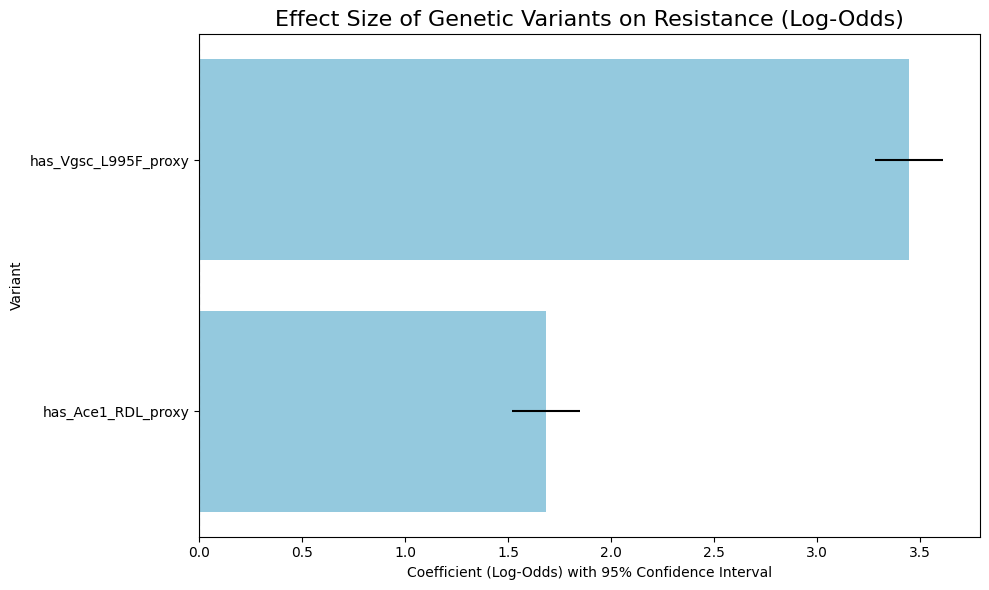

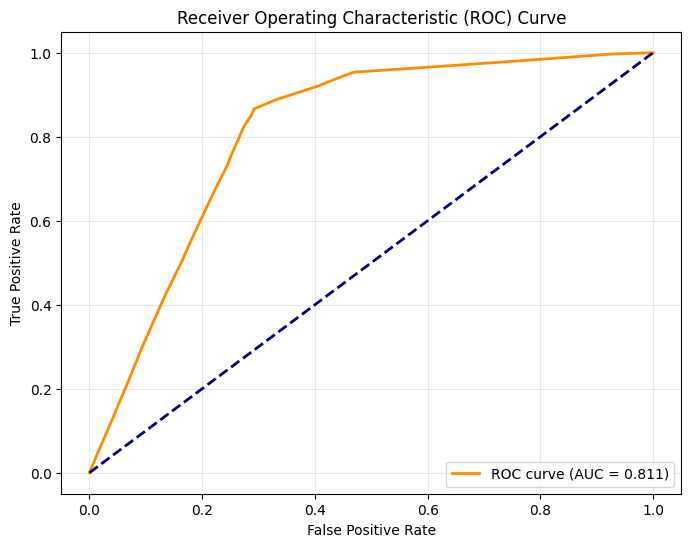

In [4]:
# --- Visualize the Model Coefficients ---

param_df = gwas_model.get_params()
plot_df_variants = param_df[param_df.index.str.startswith('has_')]

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='coefficient', 
    y=plot_df_variants.index, 
    data=plot_df_variants, 
    color='skyblue', 
    xerr=(plot_df_variants['conf_int_upper'] - plot_df_variants['conf_int_lower']) / 2
)
ax.axvline(0, color='grey', linestyle='--')
ax.set_title('Effect Size of Genetic Variants on Resistance (Log-Odds)', fontsize=16)
ax.set_ylabel('Variant')
ax.set_xlabel('Coefficient (Log-Odds) with 95% Confidence Interval')
plt.tight_layout()
plt.show()

# --- Visualize Model Accuracy with ROC Curve ---
predicted_probs = performance_metrics['predicted_probabilities']
fpr, tpr, _ = roc_curve(gwas_model.analysis_df['phenotype'], predicted_probs)
auc_score = performance_metrics['auc']

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

### 6. Modeling Genetic Interactions (Epistasis)

A simple additive model assumes each gene contributes independently. However, some biological mechanisms may require multiple mutations to function, a phenomenon known as **epistasis** or an **interaction effect**.

We can test for this by including an interaction term in our model. This allows us to see if the effect of having both mutations is greater than the sum of their individual effects.

In [5]:
# --- Fit a new model that includes an interaction term ---

print("--- Fitting Model with Interaction Term ---")

# We re-use the same analysis_df and column names
interaction_model = LogisticRegressionGWAS().fit(
    analysis_df, 
    variant_names, 
    pc_names, 
    include_interaction=True  # <-- This is the new switch
)

# Print the summary of the new model
print(interaction_model.summary())

print("\n--- Interpretation of the Interaction Term ---")
interaction_term_name = 'has_Vgsc_L995F_proxy:has_Ace1_RDL_proxy'
interaction_p_value = interaction_model.results.pvalues.get(interaction_term_name, 1)

if interaction_p_value < 0.05:
    print(f"The interaction term is STATISTICALLY SIGNIFICANT (p = {interaction_p_value:.3f}).")
    print("This suggests that the two genes work together synergistically.")
else:
    print(f"The interaction term is NOT statistically significant (p = {interaction_p_value:.3f}).")
    print("In our current simulation, there is no strong evidence that the genes have a synergistic effect beyond their individual contributions.")

--- Fitting Model with Interaction Term ---

Using formula for Logistic Regression: phenotype ~ has_Vgsc_L995F_proxy * has_Ace1_RDL_proxy + PC1 + PC2

                           Logit Regression Results                           
Dep. Variable:              phenotype   No. Observations:                22605
Model:                          Logit   Df Residuals:                    22599
Method:                           MLE   Df Model:                            5
Date:                Wed, 09 Jul 2025   Pseudo R-squ.:                  0.2838
Time:                        17:24:34   Log-Likelihood:                -6483.0
converged:                       True   LL-Null:                       -9052.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
I

### Interpretation of the Interaction Model

This model investigates the possibility of epistasis, where the effect of two genes together differs from the sum of their individual effects.

*   **Interaction Effect:** The model reveals a statistically significant coefficient for the interaction term `has_Vgsc_L995F_proxy:has_Ace1_RDL_proxy` (coef ≈ 0.99, p < 0.001). The positive coefficient suggests a synergistic relationship, where the presence of both variants provides a greater increase in resistance than would be expected from their individual effects alone.

*   **Conditional Main Effects:** With the interaction term included, the interpretation of the main effect coefficients changes:
    *   The `has_Vgsc_L995F_proxy` coefficient (≈ 2.55) now represents the estimated effect of this variant *when the Ace1 variant is absent*.
    *   Similarly, the `has_Ace1_RDL_proxy` coefficient (≈ 0.80) represents the effect of this variant *when the Vgsc variant is absent*.

This model provides a more nuanced view of the simulated genetic architecture, quantifying not only the individual effects of the variants but also the additional effect derived from their co-occurrence.